In [18]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import IPython as ipd
import IPython.display as ipd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

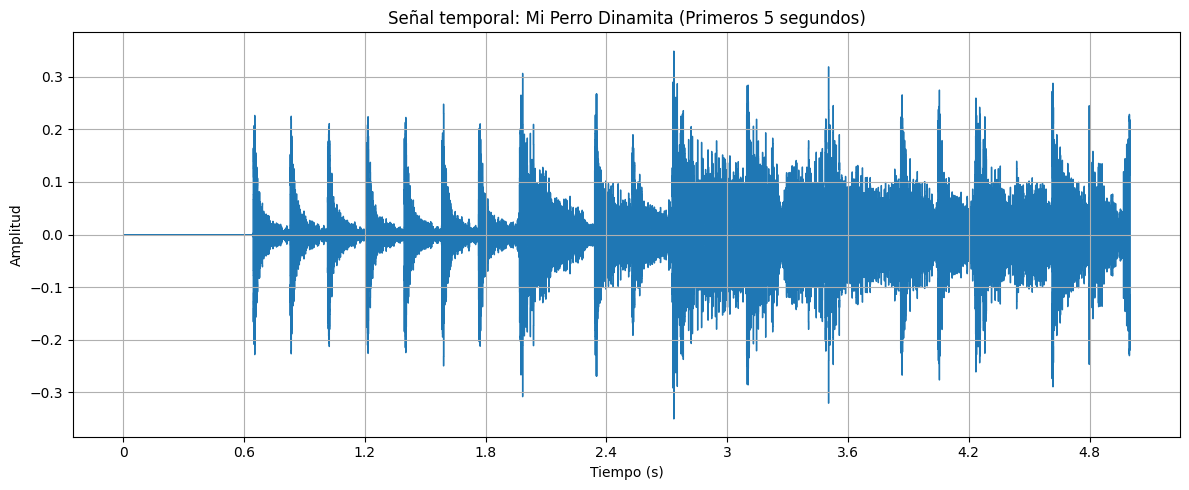

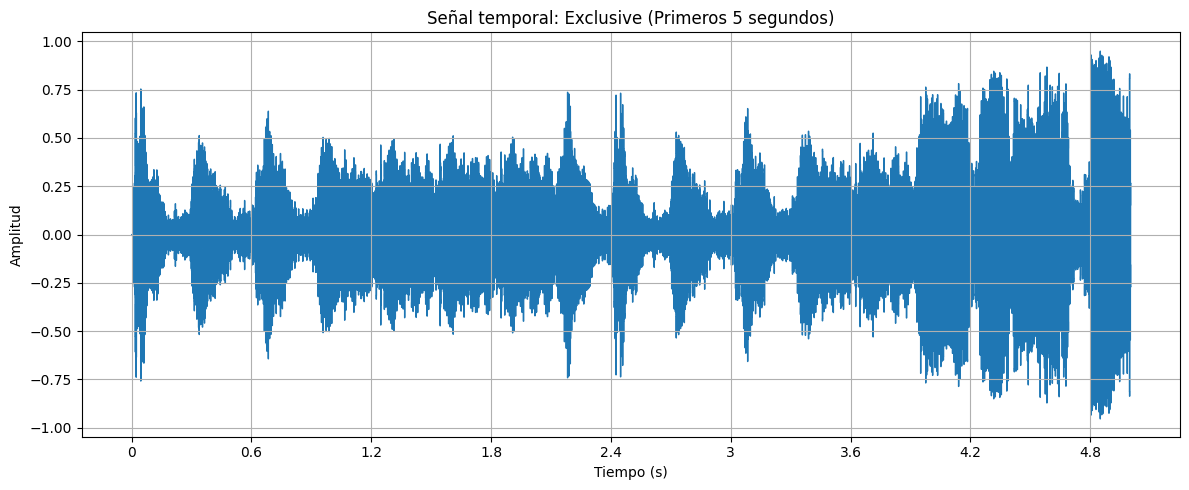

In [19]:
!wget -q -O mi_perro_dinamita.mp3 "https://github.com/mvera1412/TA136-TB056-TB057-8625/raw/main/data/mi_perro_dinamita.mp3"
!wget -q -O exclusive.mp3 "https://github.com/mvera1412/TA136-TB056-TB057-8625/raw/main/data/exclusive.mp3"


y1, sr1 = librosa.load('mi_perro_dinamita.mp3', duration=5) #y tiene la amplitud y sr la tasa de muestreo

plt.figure(figsize=(12, 5))
librosa.display.waveshow(y1, sr=sr1)
plt.title('Señal temporal: Mi Perro Dinamita (Primeros 5 segundos)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.tight_layout()
plt.show()


y2, sr2 = librosa.load('exclusive.mp3', duration=5)

plt.figure(figsize=(12, 5))
librosa.display.waveshow(y2, sr=sr2)
plt.title('Señal temporal: Exclusive (Primeros 5 segundos)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
#perro dinamita
ipd.Audio(y1, rate=sr1)

In [21]:
#exclusive
ipd.Audio(y2 , rate = sr2)

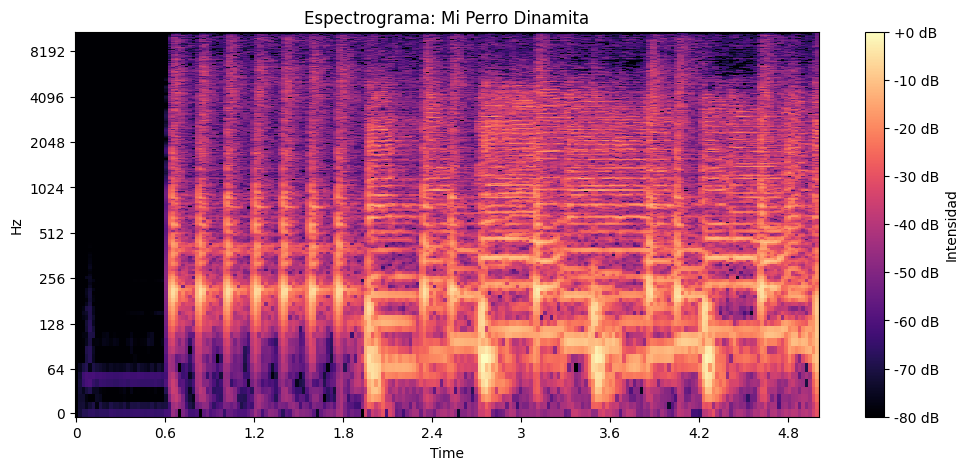

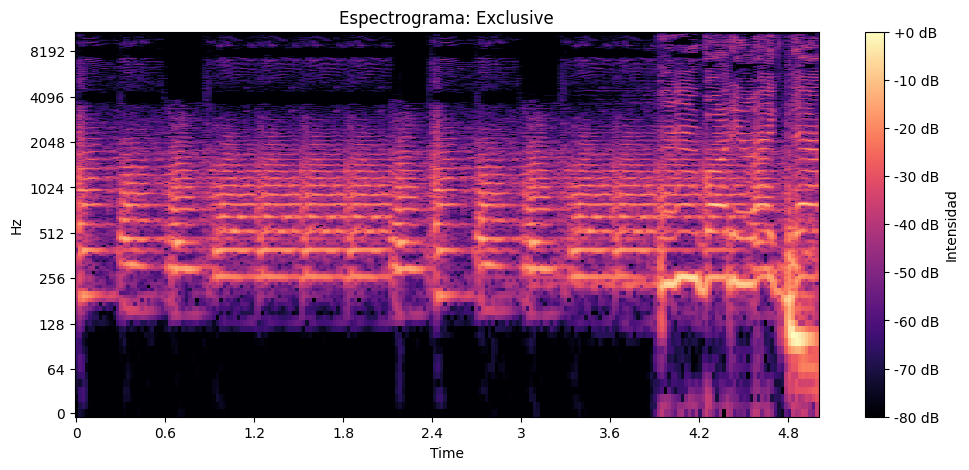

In [22]:
# Calcular la STFT. El resultado S1 es una matriz de números complejos.
S1 = librosa.stft(y1)
#lo paso a db en modulo porque la sft te devuelve le modulo y la fase
D1 = librosa.amplitude_to_db(np.abs(S1), ref=np.max)

# Graficar el espectrograma
fig, ax = plt.subplots(figsize=(12, 5))
img1 = librosa.display.specshow(D1, sr=sr1, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Espectrograma: Mi Perro Dinamita')
fig.colorbar(img1, ax=ax, format="%+2.0f dB", label='Intensidad')
plt.show()


# Repetimos el mismo proceso para la segunda señal
S2 = librosa.stft(y2)
D2 = librosa.amplitude_to_db(np.abs(S2), ref=np.max)

fig, ax = plt.subplots(figsize=(12, 5))
img2 = librosa.display.specshow(D2, sr=sr2, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Espectrograma: Exclusive')
fig.colorbar(img2, ax=ax, format="%+2.0f dB", label='Intensidad')
plt.show()

###Espectograma

Las formas que vemos no son aleatorias; describen la naturaleza de los sonidos producidos.

* **Líneas Verticales (Transitorios):** Estas líneas representan **transitorios**, que son eventos sonoros de muy corta duración pero con una gran energía distribuida a lo largo de un amplio rango de frecuencias. Esto es característico de los **instrumentos de percusión**. El golpe de una baqueta en un tambor genera una "explosión" de sonido casi instantánea en todo el espectro. En la imagen, estas líneas verticales marcan el **ataque rítmico** del bombo (en las frecuencias más graves) y la tarola (en el rango medio-alto).

* **Líneas Horizontales (Tonalidad):** Estas líneas representan los armonicos, donde la energía se concentra en una frecuencia fundamental y sus **armónicos** durante un período de tiempo. Esto es típico de los **instrumentos melódicos y armónicos**. La línea horizontal más brillante y baja es la **frecuencia fundamental** de la nota del bajo. Las líneas más tenues que aparecen por encima a intervalos regulares son sus armónicos, que definen el **timbre** o "color" del instrumento.


#### La Intensidad y la Mezcla

El color no solo indica el volumen, sino que revela la **dinámica y la jerarquía de la mezcla**.

* **Escala Logarítmica (`dB`):** La intensidad se mide en decibeles (`dB`), una **escala logarítmica** que se asemeja a la percepción humana del volumen. El punto `+0 dB` (amarillo más brillante) se asigna al punto más intenso del fragmento, y todo lo demás se mide en relación a ese máximo.

* **Análisis de la Mezcla:** Los colores más brillantes nos muestran qué elementos dominan la energía de la canción. En este caso, el **bombo y la línea de bajo** son consistentemente los elementos con mayor intensidad. Esto nos dice que son la **base fundamental** de la mezcla, proporcionando el pulso rítmico y armónico. La energía en las frecuencias más altas (platillos) es menos intensa y más difusa, ocupando un plano secundario en la mezcla.

In [23]:
def crear_dataset(cancion1, cancion2, seg_inicio, seg_fin, n_fft=2048, hop_length=512):

    duracion = seg_fin - seg_inicio

    #Solapamiento del 75%: Esto define el hop_length (el paso entre cada ventana).
    #Si la ventana es de 2048 puntos y queremos que la siguiente se superponga en un 75%, significa que avanzamos solo un 25% en cada paso.
    #hop_length=n_fft×(1−solapamiento)
    #hop_length=2048×(1−0.75)=2048×0.25=512
    y1, sr1 = librosa.load(cancion1, duration=duracion, offset=seg_inicio)
    y2, sr2 = librosa.load(cancion2, duration=duracion, offset=seg_inicio)

    s11 = librosa.stft(y1, n_fft=n_fft, hop_length=hop_length, window='hann')
    s22 = librosa.stft(y2, n_fft=n_fft, hop_length=hop_length, window='hann')

    s1 = librosa.amplitude_to_db(np.abs(s11), ref=np.max)
    s2 = librosa.amplitude_to_db(np.abs(s22), ref=np.max)
    #Cada COLUMNA es un instante en el tiempo
    #Cada FILA es una banda de frecuencia específica

    labels1 = np.zeros(s1.shape[1], dtype=int)
    labels2 = np.ones(s2.shape[1], dtype=int)

    x = np.concatenate((s1.T, s2.T), axis=0)
    y = np.concatenate((labels1, labels2))

    return x, y

In [24]:
#armado de la base de datos

x_train, y_train = crear_dataset(cancion1='mi_perro_dinamita.mp3',cancion2='exclusive.mp3',seg_inicio=0,seg_fin=5)

print("\n--- Base de Datos de Entrenamiento Construida ---")
print(f"Forma de la matriz de features (X): {x_train.shape}")
print(f"Forma del vector de etiquetas (y): {y_train.shape}")


--- Base de Datos de Entrenamiento Construida ---
Forma de la matriz de features (X): (432, 1025)
Forma del vector de etiquetas (y): (432,)


In [25]:
#repito para armar los datos de validacion
# del segundo 30 al 35
x_validacion, y_validacion = crear_dataset(cancion1='mi_perro_dinamita.mp3',cancion2='exclusive.mp3',seg_inicio=30,seg_fin=35)


print("\n--- Base de Datos de Entrenamiento Construida ---")
print(f"Forma de la matriz de features (X): {x_validacion.shape}")
print(f"Forma del vector de etiquetas (y): {y_validacion.shape}")


--- Base de Datos de Entrenamiento Construida ---
Forma de la matriz de features (X): (432, 1025)
Forma del vector de etiquetas (y): (432,)


In [26]:
x_test , y_test = crear_dataset(cancion1='mi_perro_dinamita.mp3',cancion2='exclusive.mp3',seg_inicio=60,seg_fin=90)

print("\n--- Base de Datos de Entrenamiento Construida ---")
print(f"Forma de la matriz de features (X): {x_test.shape}")
print(f"Forma del vector de etiquetas (y): {y_test.shape}")


--- Base de Datos de Entrenamiento Construida ---
Forma de la matriz de features (X): (2584, 1025)
Forma del vector de etiquetas (y): (2584,)


###Aprendizaje supervisado

In [27]:
#funcion de regresion logistica
def reg_log(x_train_norm, y_train, x_test_norm, y_test, x_validacion_norm , y_validacion , valores_c):
    accuracies_validacion = []
    for c in valores_c:
      modelo = LogisticRegression(C=c, max_iter=1000, random_state=22)
      modelo.fit(x_train_norm, y_train)
      # Evalúa el modelo en el CONJUNTO DE VALIDACIÓN
      y_pred_val = modelo.predict(x_validacion_norm)
      accuracy_validacion = accuracy_score(y_validacion, y_pred_val)
      accuracies_validacion.append(accuracy_validacion)

    mejor_indice = np.argmax(accuracies_validacion)
    mejor_c = valores_c[mejor_indice]
    mejor_accuracy = accuracies_validacion[mejor_indice]

    regresion_logistica = LogisticRegression(C=mejor_c, max_iter=1000, random_state=22)
    regresion_logistica.fit(x_train_norm, y_train)

    accuracy_rl = regresion_logistica.score(x_test_norm, y_test)
    return accuracy_rl, accuracies_validacion, mejor_c

Accuracy en el conjunto de prueba: 0.6768575851393189
mejor_c 0.667


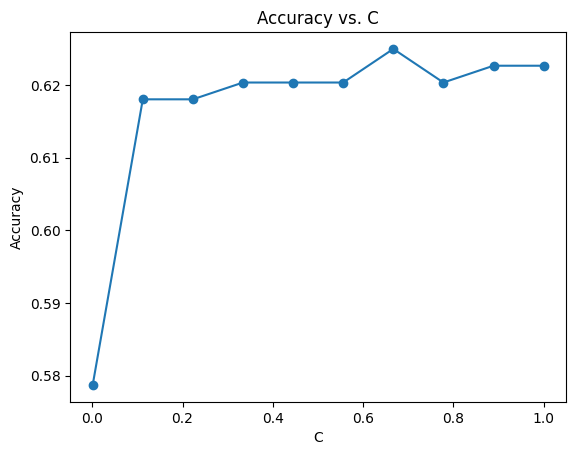

In [28]:
#Normalizo para cuando lo necesite
scaler = StandardScaler()

x_train_norm = scaler.fit_transform(x_train)
x_validacion_norm = scaler.transform(x_validacion)
x_test_norm = scaler.transform(x_test)

#defino los valores de c en lo que se va a iterar
valores_c = np.linspace(0.001, 1, 10)

accuracy_rl, accuracies_validacion, mejor_c = reg_log(x_train_norm, y_train, x_test_norm, y_test, x_validacion_norm , y_validacion , valores_c)
print("Accuracy en el conjunto de prueba:", accuracy_rl)
print("mejor_c" , mejor_c)
plt.plot(valores_c, accuracies_validacion , marker= 'o')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. C')
plt.show()


Se comenzó el análisis con un modelo de **Regresión Logística**. El hiperparámetro fundamental en este modelo es **C**, el cual controla la inversa de la fuerza de la regularización, una técnica crucial para controlar el sobreajuste. Un valor de **C** pequeño implica una regularización fuerte, resultando en un modelo más simple, mientras que un valor de **C** grande implica una regularización débil, permitiendo un modelo más complejo.

El objetivo fue encontrar el valor de **C** que maximizara la **accuracy** en el **conjunto de validación**, buscando el mejor equilibrio entre sesgo y varianza. Para ello, se realizó una búsqueda probando una serie de valores de **C** en un rango predefinido. Se eligió este rango para poder explorar el efecto de diferentes intensidades de regularización sobre el rendimiento del modelo.



###LDA Y QDA

In [29]:
def lda(x_train_norm, y_train, x_test_norm , y_test):
    modelo_lda = LinearDiscriminantAnalysis()
    modelo_lda.fit(x_train_norm, y_train)
    accuracy_lda = modelo_lda.score(x_test_norm, y_test)
    return accuracy_lda


In [30]:
accuracy_lda = lda(x_train_norm, y_train, x_test_norm, y_test)
print("Accuracy en el conjunto de prueba (LDA):", accuracy_lda)

Accuracy en el conjunto de prueba (LDA): 0.6199690402476781


El LDA asume que los datos de cada clase siguen una distribución normal multivariada con igual
matriz de covarianza, y busca encontrar combinaciones lineales de las características que maximicen
la separación entre clases. A diferencia de otros modelos como la regresión logística o SVM, LDA
no requiere la selección de hiperparámetros, ya que sus parámetros se calculan de forma analítica
a partir del conjunto de entrenamiento.

Por este motivo, no se realizó una búsqueda de validación, sino que se entrenó el modelo directamente
y se evaluó su desempeño en el conjunto de prueba. El accuracy obtenido fue de aproximadamente 0.6 en el conjunto de prueba, lo que indica un
desempeño cercano al de un clasificador aleatorio. Este resultado puede atribuirse a la
simplicidad del modelo y a los supuestos que realiza, ya que LDA asume que las clases presentan
distribuciones normales con igual matriz de covarianza y que la separación entre ellas es lineal.


In [31]:
def qda(x_train_norm, y_train, x_test_norm, y_test,x_validacion_norm,y_validacion,valores_reg):
  mejor_accuracy_qda = 0
  mejor_reg_param = 0
  for reg in valores_reg:
    modelo_qda = QuadraticDiscriminantAnalysis(reg_param=reg)
    modelo_qda.fit(x_train_norm, y_train)
    accuracy_val = modelo_qda.score(x_validacion_norm, y_validacion)
    if accuracy_val > mejor_accuracy_qda:
        mejor_accuracy_qda = accuracy_val
        mejor_reg_param = reg

  # Luego, entrenas el modelo final con el mejor reg_param y lo evalúas en el conjunto de test.
  modelo_qda_final = QuadraticDiscriminantAnalysis(reg_param=mejor_reg_param)
  modelo_qda_final.fit(x_train_norm, y_train)
  accuracy_qda_final = modelo_qda_final.score(x_test_norm, y_test)

  return accuracy_qda_final, mejor_reg_param


In [32]:
valores_reg = np.linspace(0, 1, 10)
accuracy_qda_final, mejor_reg_param = qda(x_train_norm, y_train, x_test_norm, y_test, x_validacion_norm , y_validacion, valores_reg)
print(f"Mejor accuracy en el conjunto de prueba (QDA): {accuracy_qda_final}")
print(f"Mejor reg_param para QDA: {mejor_reg_param}")


/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Mejor accuracy en el conjunto de prueba (QDA): 0.8184984520123839
Mejor reg_param para QDA: 0.1111111111111111


/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


El algoritmo **QDA** necesita calcular la inversa de la matriz de covarianza de cada clase ($\Sigma_k$). Esto puede fallar si la matriz es **singular**, lo que ocurre cuando las features están muy correlacionadas.  

El hiperparámetro `reg_param` ($\gamma$) soluciona esto creando una **matriz regularizada**:

$$\tilde{\Sigma}_k = (1 - \gamma) \hat{\Sigma}_k + \gamma \cdot \bar{\sigma}^2_k I$$

donde $I$ es la matriz identidad. En esencia, `reg_param` **inyecta estabilidad**, evitando errores numéricos y ayudando a reducir el sobreajuste. Un valor de $\gamma > 0$ previene `warnings` y hace el modelo más robusto.


En el caso del **QDA**, el mejor desempeño se obtuvo con `reg_param ≈ 0.11`, alcanzando un **accuracy de ~0.82** en el conjunto de prueba.  

Esto se debe a que, a diferencia de LDA, QDA puede imponer **fronteras de decisión no lineales**, lo que permite clasificar de manera más precisa las muestras, especialmente cuando las distribuciones de las clases no son linealmente separables.  
Además, la **regularización** mediante `reg_param` estabiliza la estimación de la matriz de covarianza por clase, evitando problemas de singularidad y garantizando que los cálculos sean numéricamente estables.  

Esta combinación de **fronteras cuadráticas flexibles** y **regularización ligera** permite que el modelo capture diferencias sutiles entre las clases sin sobreajustarse al ruido, lo que explica por qué QDA logra un rendimiento considerablemente mejor que LDA en este problema de clasificación de espectrogramas de audio.



###KNN

In [53]:
def func_knn(x_train_norm, y_train, x_test_norm, y_test, x_validacion_norm, y_validacion):
  accuracy_knn = []
  #busco la accuracy para distintos k y me quedo con el que de mas grande
  for k in range(1, 11): # Changed to use range for integer k values
      modelo_knn = KNeighborsClassifier(n_neighbors=k)
      modelo_knn.fit(x_train_norm, y_train)
      y_pred_knn = modelo_knn.predict(x_validacion_norm)
      accuracy_knn.append(accuracy_score(y_validacion, y_pred_knn))

  mejor_k = np.argmax(accuracy_knn) + 1 #poruqe los indices arrancan en 0

  #ahora que tengo el de mayor accurracy entreno y verifico con el conjunto de testeo
  knn = KNeighborsClassifier(n_neighbors=mejor_k)
  knn.fit(x_train_norm, y_train)
  y_pred_knn_test = knn.predict(x_test_norm)
  acc_knn_test = accuracy_score(y_test, y_pred_knn_test)
  return acc_knn_test, mejor_k, accuracy_knn

Mejor k para KNN: 3
Mejor accuracy en el conjunto de prueba (KNN): 0.6931114551083591
Accuracy en el conjunto de validacion (KNN): [0.6689814814814815, 0.6203703703703703, 0.6736111111111112, 0.6342592592592593, 0.6481481481481481, 0.6134259259259259, 0.6319444444444444, 0.6041666666666666, 0.6134259259259259, 0.5995370370370371]


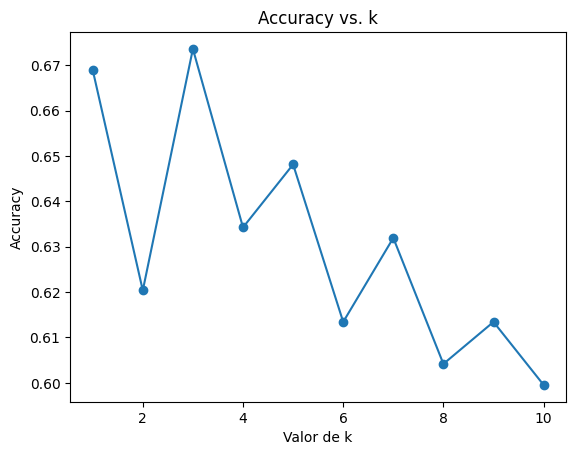

In [54]:
acc_knn_test, mejor_k, accuracy_knn_validacion = func_knn(x_train, y_train, x_test, y_test, x_validacion, y_validacion)
print(f"Mejor k para KNN: {mejor_k}")
print(f"Mejor accuracy en el conjunto de prueba (KNN): {acc_knn_test}")
print("Accuracy en el conjunto de validacion (KNN):", accuracy_knn_validacion)

plt.plot(range(1, 11), accuracy_knn_validacion, marker='o')
plt.xlabel('Valor de k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.show()



Se entrenaron distintos modelos **KNN** variando el número de vecinos \(k\) entre 1 y 10, evaluando el desempeño en el conjunto de validación para seleccionar el mejor parámetro. El mejor resultado se obtuvo con **k = 3**, alcanzando un **accuracy de aproximadamente 0.7** en el conjunto de prueba.  

Esto indica que el modelo clasifica cada punto de prueba considerando los **tres vecinos más cercanos** en el conjunto de entrenamiento. Al utilizar varios vecinos, KNN logra un equilibrio entre seguir la estructura local de los datos y suavizar el efecto del ruido, lo que evita el sobreajuste.

Se puede observar del gráfico que al tomar demasiados vecinos la accuracy comienza a bajar. Esto se debe a que al considerar muchos vecinos, el modelo empieza a promediar información de puntos de otras clases, lo que **suaviza demasiado la frontera de decisión** y hace que KNN pierda capacidad de capturar las diferencias locales entre clases. En otras palabras, aumenta el **sesgo** del modelo y disminuye su precisión en la clasificación de los datos.




###SVM

In [36]:
def func_svm(x_train_norm, y_train, x_test_norm, y_test, x_validacion_norm, y_validacion, C_values, gamma_values):
    best_acc = 0
    best_c = None
    best_gamma = None
    results = []

    # Buscar mejor combinación en validación
    for C in C_values:
        for gamma in gamma_values:
            modelo_svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=22)
            modelo_svm.fit(x_train_norm, y_train)
            y_pred_svm = modelo_svm.predict(x_validacion_norm)
            acc_val = accuracy_score(y_validacion, y_pred_svm)
            results.append((C, gamma, acc_val))

            if acc_val > best_acc:
                best_acc = acc_val
                best_c = C
                best_gamma = gamma

    # Entrenar modelo final con los mejores hiperparámetros
    modelo_svm_final = SVC(kernel='rbf', C=best_c, gamma=best_gamma, random_state=22)
    modelo_svm_final.fit(x_train_norm, y_train)
    y_pred_svm_test = modelo_svm_final.predict(x_test_norm)
    acc_test = accuracy_score(y_test,y_pred_svm_test)

    return acc_test, results, best_c , best_gamma

In [37]:
# Definir los valores de C y gamma a explorar

C_values = [0.001, 0.1, 1, 10, 100]
gamma_values = [0.0001 , 0.001, 0.01, 0.1, 1]
accuracy_svm, accuracies, best_c, best_gamma = func_svm(x_train_norm, y_train, x_test_norm, y_test, x_validacion_norm, y_validacion,C_values,gamma_values)
print(f"Accuracy test svm {accuracy_svm}")
print(f"Mejor C: {best_c}")
print(f"Mejor gamma: {best_gamma}")


Accuracy test svm 0.7604489164086687
Mejor C: 1
Mejor gamma: 0.001


### Modelo SVM con Kernel RBF  

Se entrenó un modelo **SVM (Support Vector Machine)** con **kernel RBF (Radial Basis Function)**, el cual busca encontrar una **frontera de decisión óptima** que separe las clases maximizando el **margen** entre los puntos de diferentes categorías.  
A diferencia de un clasificador lineal, el kernel RBF permite capturar **relaciones no lineales** entre las variables, mapeando los datos a un **espacio de mayor dimensión** donde una separación lineal resulta posible.  

Matemáticamente, el kernel RBF se define como:  

$$
K(x_i, x_j) = e^{(-\gamma \|x_i - x_j\|^2)}
$$

donde:
  - gamma controla el **alcance de la influencia** de cada muestra de entrenamiento.  
  - Valores grandes de gamma hacen que cada punto tenga una influencia muy localizada, lo que genera fronteras muy ajustadas,riesgo de overfitting  
  - Valores pequeños de gamma generan fronteras más suaves, lo que puede llevar a **subajuste**.  

Por su parte, el parámetro \( C \) controla la **penalización por errores de clasificación**:  
- Un valor grande de \( C \) busca minimizar los errores en entrenamiento, aunque puede reducir la generalización.  
- Un valor pequeño de \( C \) permite un margen más ancho, tolerando algunos errores pero mejorando la capacidad de generalizar.  

Se exploraron distintas combinaciones de  C  y gamma utilizando el conjunto de validación, y se seleccionó aquella que maximizó el accuracy.  
El mejor desempeño se obtuvo con **C = 1** y **gamma = 0.001**, alcanzando un accuracy de aproximadamente 0.76 en el conjunto de testeo.  

Este resultado refleja la **capacidad del kernel RBF para modelar fronteras no lineales**, adaptándose a distribuciones de datos complejas donde modelos lineales (como la regresión logística o LDA) resultan insuficientes.  


###Arboles de decision



In [38]:
def func_arbol(x_train, y_train, x_test, y_test, x_validacion, y_validacion):
    # Entreno el árbol base
    modelo_arbol = DecisionTreeClassifier(random_state=22, criterion='entropy')
    modelo_arbol.fit(x_train, y_train)

    # Obtengo los posibles valores de alpha (para poda)
    ccp_path = modelo_arbol.cost_complexity_pruning_path(x_train, y_train)
    ccp_alphas = ccp_path.ccp_alphas

    accuracies_validacion = []
    mejor_alpha = 0
    mejor_acc_val = 0

    # Busco el alpha con mejor accuracy en validación
    for alpha in ccp_alphas[1:]:
        arbol_podado = DecisionTreeClassifier(random_state=22, criterion='entropy', ccp_alpha=alpha)
        arbol_podado.fit(x_train, y_train)
        y_pred_val = arbol_podado.predict(x_validacion)
        acc_val = accuracy_score(y_validacion, y_pred_val)
        accuracies_validacion.append(acc_val)

        if acc_val > mejor_acc_val:
            mejor_acc_val = acc_val
            mejor_alpha = alpha

    return mejor_alpha


Accuracy en el conjunto de prueba: 0.7267801857585139
mejor alpha 0.020597269234969424


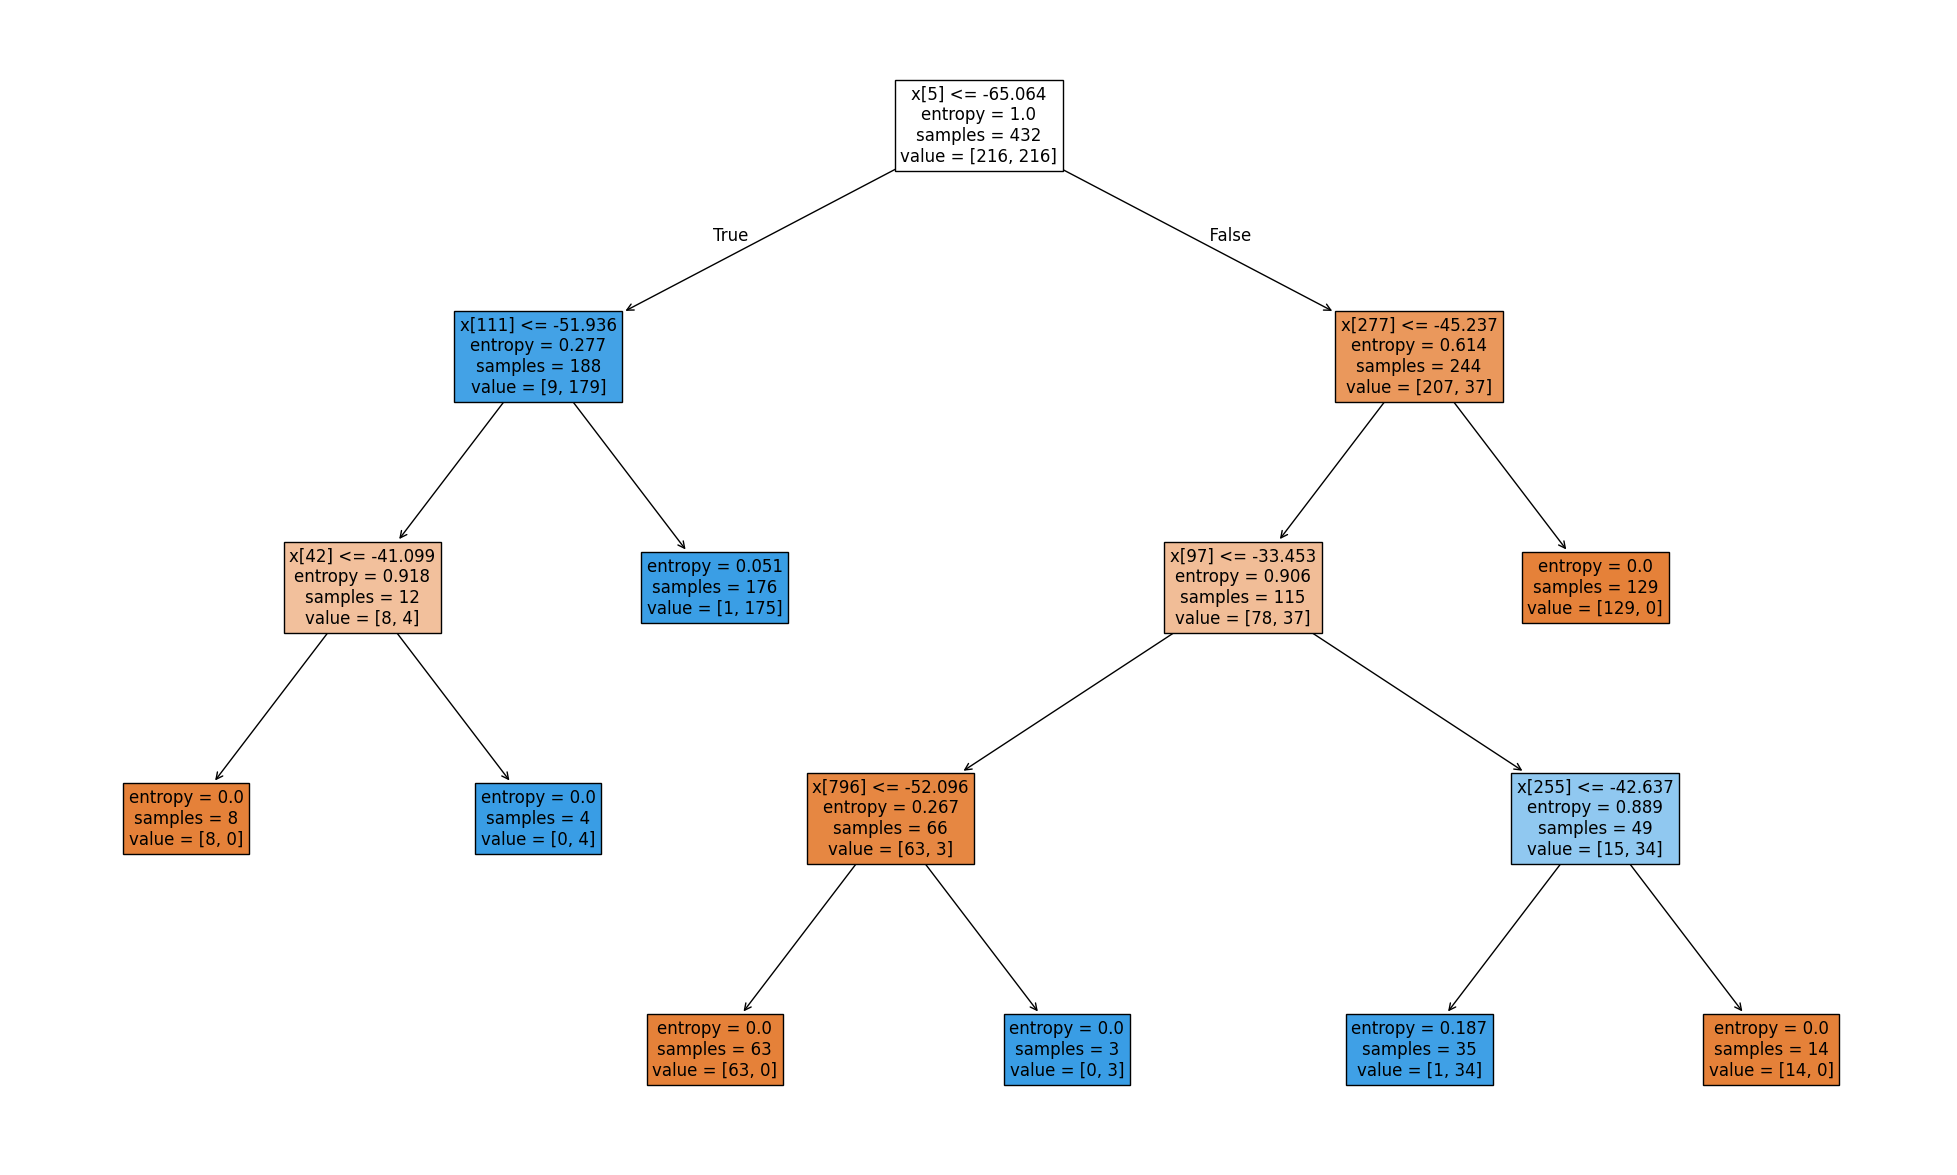

In [39]:
#defino el modelo del arbol y saco los alphas para evaluar cual es el que me da mayor accuracy

alpha_final = func_arbol(x_train, y_train,x_test, y_test, x_validacion, y_validacion)

# Entreno árbol final con el mejor alpha}
arbol_final = DecisionTreeClassifier(random_state=22, criterion='entropy', ccp_alpha=alpha_final)
arbol_final.fit(x_train, y_train)
y_pred_test = arbol_final.predict(x_test)
accuracy_arbol = accuracy_score(y_test, y_pred_test)
print(f"Accuracy en el conjunto de prueba: {accuracy_arbol}")
print("mejor alpha" , alpha_final)


plt.figure(figsize=(25,15))
plot_tree(arbol_final, filled=True , fontsize=12)
plt.show()

En este caso el hiperparametro que se busca es el $\alpha$, el cual es el encargado de la **poda** ,la cual es una técnica utilizada para reducir el tamaño de un árbol de decisión, eliminando aquellas ramas que aportan poca o ninguna mejora en la capacidad predictiva del modelo.  
Su objetivo principal es eliminar el overfitting, es decir, que el árbol aprenda detalles o ruido específicos del conjunto de entrenamiento y pierda capacidad de generalización sobre datos nuevos.

En este caso, el método utilizado es la poda por complejidad de costo (*Cost Complexity Pruning*).  
Esta técnica define una medida de costo total para un árbol \( T \):

$$
R_\alpha(T) = R(T) + \alpha \times |T|
$$

donde:

-  R(T) : error del árbol sobre los datos de entrenamiento.  
- |T|: número de hojas (complejidad del árbol).  
- $\alpha$: parámetro de penalización que controla el equilibrio entre exactitud y simplicidad.


\begin{cases}
\alpha = 0 & \Rightarrow \text{El árbol crece sin restricción y tiende a sobreajustar.} \\
\alpha > 0 & \Rightarrow \text{Se penalizan los árboles grandes y se eliminan ramas, obteniendo un modelo más simple.}
\end{cases}


El procedimiento consiste en calcular una secuencia de valores posibles de $\alpha$ mediante el método cost_complexity_pruning_path().  
Luego se reentrena el modelo con distintos valores de ccp_alpha y se selecciona el que maximiza el rendimiento en validación, en este caso analizando la accuracy



In [40]:
from IPython.display import Markdown

tabla = f"""
| Modelo                                   | Hiperparámetros principales               | Accuracy (Test) |
|------------------------------------------|-------------------------------------------|----------------:|
| **Regresión Logística**                  | C = {mejor_c:.4f}                         | {accuracy_rl:.4f} |
| **Análisis Discriminante Lineal (LDA)**  | –                                         | {accuracy_lda:.4f} |
| **Análisis Discriminante Cuadrático (QDA)** | reg_param = {mejor_reg_param:.4f}        | {accuracy_qda_final:.4f} |
| **K-Nearest Neighbors (KNN)**            | k = {mejor_k}                             | {acc_knn_test:.4f} |
| **SVM (kernel RBF)**                     | C = {best_c}, γ = {best_gamma}            | {accuracy_svm:.4f} |
| **Árbol de Decisión**                    | α = {alpha_final}                         | {accuracy_arbol:.4f} |
"""

display(Markdown(tabla))



| Modelo                                   | Hiperparámetros principales               | Accuracy (Test) |
|------------------------------------------|-------------------------------------------|----------------:|
| **Regresión Logística**                  | C = 0.6670                         | 0.6769 |
| **Análisis Discriminante Lineal (LDA)**  | –                                         | 0.6200 |
| **Análisis Discriminante Cuadrático (QDA)** | reg_param = 0.1111        | 0.8185 |
| **K-Nearest Neighbors (KNN)**            | k = 3                             | 0.6931 |
| **SVM (kernel RBF)**                     | C = 1, γ = 0.001            | 0.7604 |
| **Árbol de Decisión**                    | α = 0.020597269234969424                         | 0.7268 |


###Aprendizaje supervisado

llamaremos manifold o variedad al espacio efectivo en el que habitan
los datos, PCA encuentra este manifold buscando las direcciones de máxima varianza en los datos.

In [41]:
#Me quedo con los primeros 30 componentes principales
pca = PCA(n_components=30)

x_train_pca = pca.fit_transform(x_train_norm)
x_validacion_pca = pca.transform(x_validacion_norm)
x_test_pca = pca.transform(x_test_norm)

# Mostrar cuánta varianza total se conserva
varianza_total = np.sum(pca.explained_variance_ratio_)
print(f"Varianza explicada total por las 30 componentes: {varianza_total:.4f}")

Varianza explicada total por las 30 componentes: 0.8736


Se aplicó **Análisis de Componentes Principales (PCA)** con el objetivo de reducir la dimensionalidad de los datos y eliminar redundancias entre características correlacionadas.  
PCA transforma las variables originales en un nuevo conjunto de variables no correlacionadas denominadas **componentes principales**, ordenadas según la varianza que explican en los datos.  

En este caso, se redujo la dimensión a 30 componentes principales,
esta reducción permite disminuir la complejidad del modelo, mejorar la eficiencia computacional y mitigar el riesgo de sobreajuste, manteniendo la mayor cantidad de información posible.





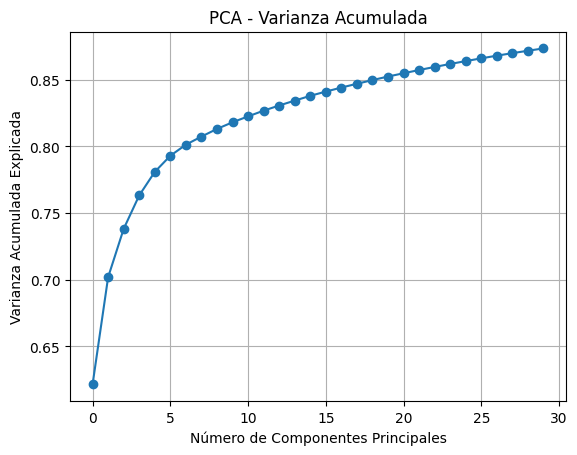

In [42]:
#grafico de como se acumula  varianza en funcion de las componentes principales
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('PCA - Varianza Acumulada')
plt.grid(True)
plt.show()


En PCA se seleccionan las componentes principales que concentran la mayor parte de la varianza de los datos, con el objetivo de representarlos en un espacio de menor dimensión. De este modo, se eliminan variables o características redundantes como aquellas frecuencias que aportan información repetida o poco significativa, conservando únicamente las direcciones más relevantes que describen la estructura esencial del conjunto de datos.

Se puede observar en el grafico como evoluciona la varianza acumulada al aumentar las componentes principales, las primeras acumulan la mayoria de la varianza y a medida que se aumentan se empieza a aplanar la curva, lo que indica que no tendria sentido seguir aumentando la cantidad de componentes utilizadas

Accuracy reglog pca: 0.7078173374613003
mejor_c 0.334


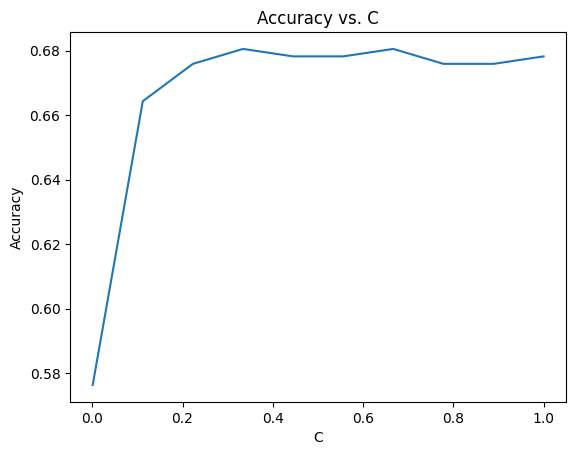

In [43]:
#vuelvo a probar todos los metodos pero ahora con las componentes reducidas
#x_train_pca_norm = scaler.fit_transform(x_train_pca)
#x_validacion_pca_norm = scaler.transform(x_validacion_pca)
#x_test_pca_norm = scaler.transform(x_test_pca)

x_train_pca_norm = x_train_pca
x_validacion_pca_norm = x_validacion_pca
x_test_pca_norm = x_test_pca

valores_c = np.linspace(0.001, 1, 10)
accuracy_rl_pca, accuracies_validacion_pca, mejor_c_pca = reg_log(x_train_pca_norm, y_train, x_test_pca_norm, y_test, x_validacion_pca_norm , y_validacion , valores_c)
print("Accuracy reglog pca:", accuracy_rl_pca)
print("mejor_c" , mejor_c_pca)
plt.plot(valores_c, accuracies_validacion_pca)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. C')
plt.show()


In [44]:
acc_lda_pca = lda(x_train_pca_norm, y_train, x_test_pca_norm, y_test)
print("Accuracy en el conjunto de prueba (LDA):", acc_lda_pca)


Accuracy en el conjunto de prueba (LDA): 0.6656346749226006


In [45]:
accuracy_qda_pca, mejor_reg_param = qda(x_train_pca_norm, y_train, x_test_pca_norm, y_test, x_validacion_pca_norm , y_validacion, valores_reg)
print(f"Mejor accuracy en el conjunto de prueba (QDA): {accuracy_qda_pca}")
print(f"Mejor reg_param para QDA: {mejor_reg_param}")

Mejor accuracy en el conjunto de prueba (QDA): 0.760061919504644
Mejor reg_param para QDA: 0.0


Mejor k para KNN: 1
Mejor accuracy en el conjunto de prueba (KNN): 0.7113003095975232
Accuracy en el conjunto de validacion (KNN): [0.6898148148148148, 0.625, 0.6597222222222222, 0.6342592592592593, 0.6458333333333334, 0.6087962962962963, 0.6180555555555556, 0.6064814814814815, 0.6111111111111112, 0.6018518518518519]


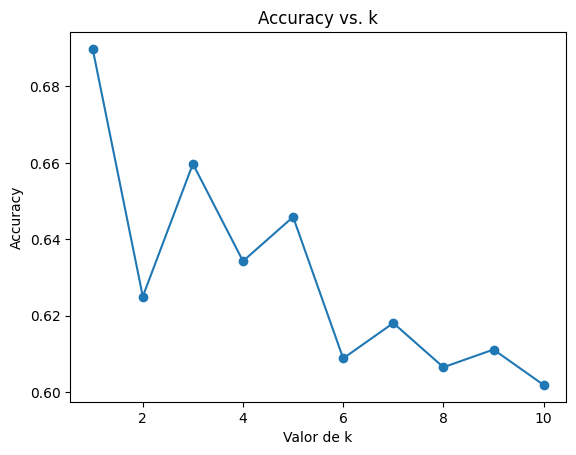

In [46]:
accuracy_knn_pca, mejor_k, accuracy_knn = func_knn(x_train_pca, y_train, x_test_pca, y_test, x_validacion_pca , y_validacion)
print(f"Mejor k para KNN: {mejor_k}")
print(f"Mejor accuracy en el conjunto de prueba (KNN): {accuracy_knn_pca}")
print("Accuracy en el conjunto de validacion (KNN):", accuracy_knn)

plt.plot(range(1, 11), accuracy_knn, marker='o')
plt.xlabel('Valor de k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.show()

In [47]:
accuracy_svm_pca, accuracies_pca, best_c_pca, best_gamma_pca = func_svm(x_train_pca_norm, y_train, x_test_pca_norm, y_test, x_validacion_pca_norm , y_validacion,C_values,gamma_values)
print(f"Accuracy test svm {accuracy_svm_pca}")

Accuracy test svm 0.8184984520123839


Accuracy en el conjunto de prueba: 0.7004643962848297
mejor alpha 0.014753166096614756


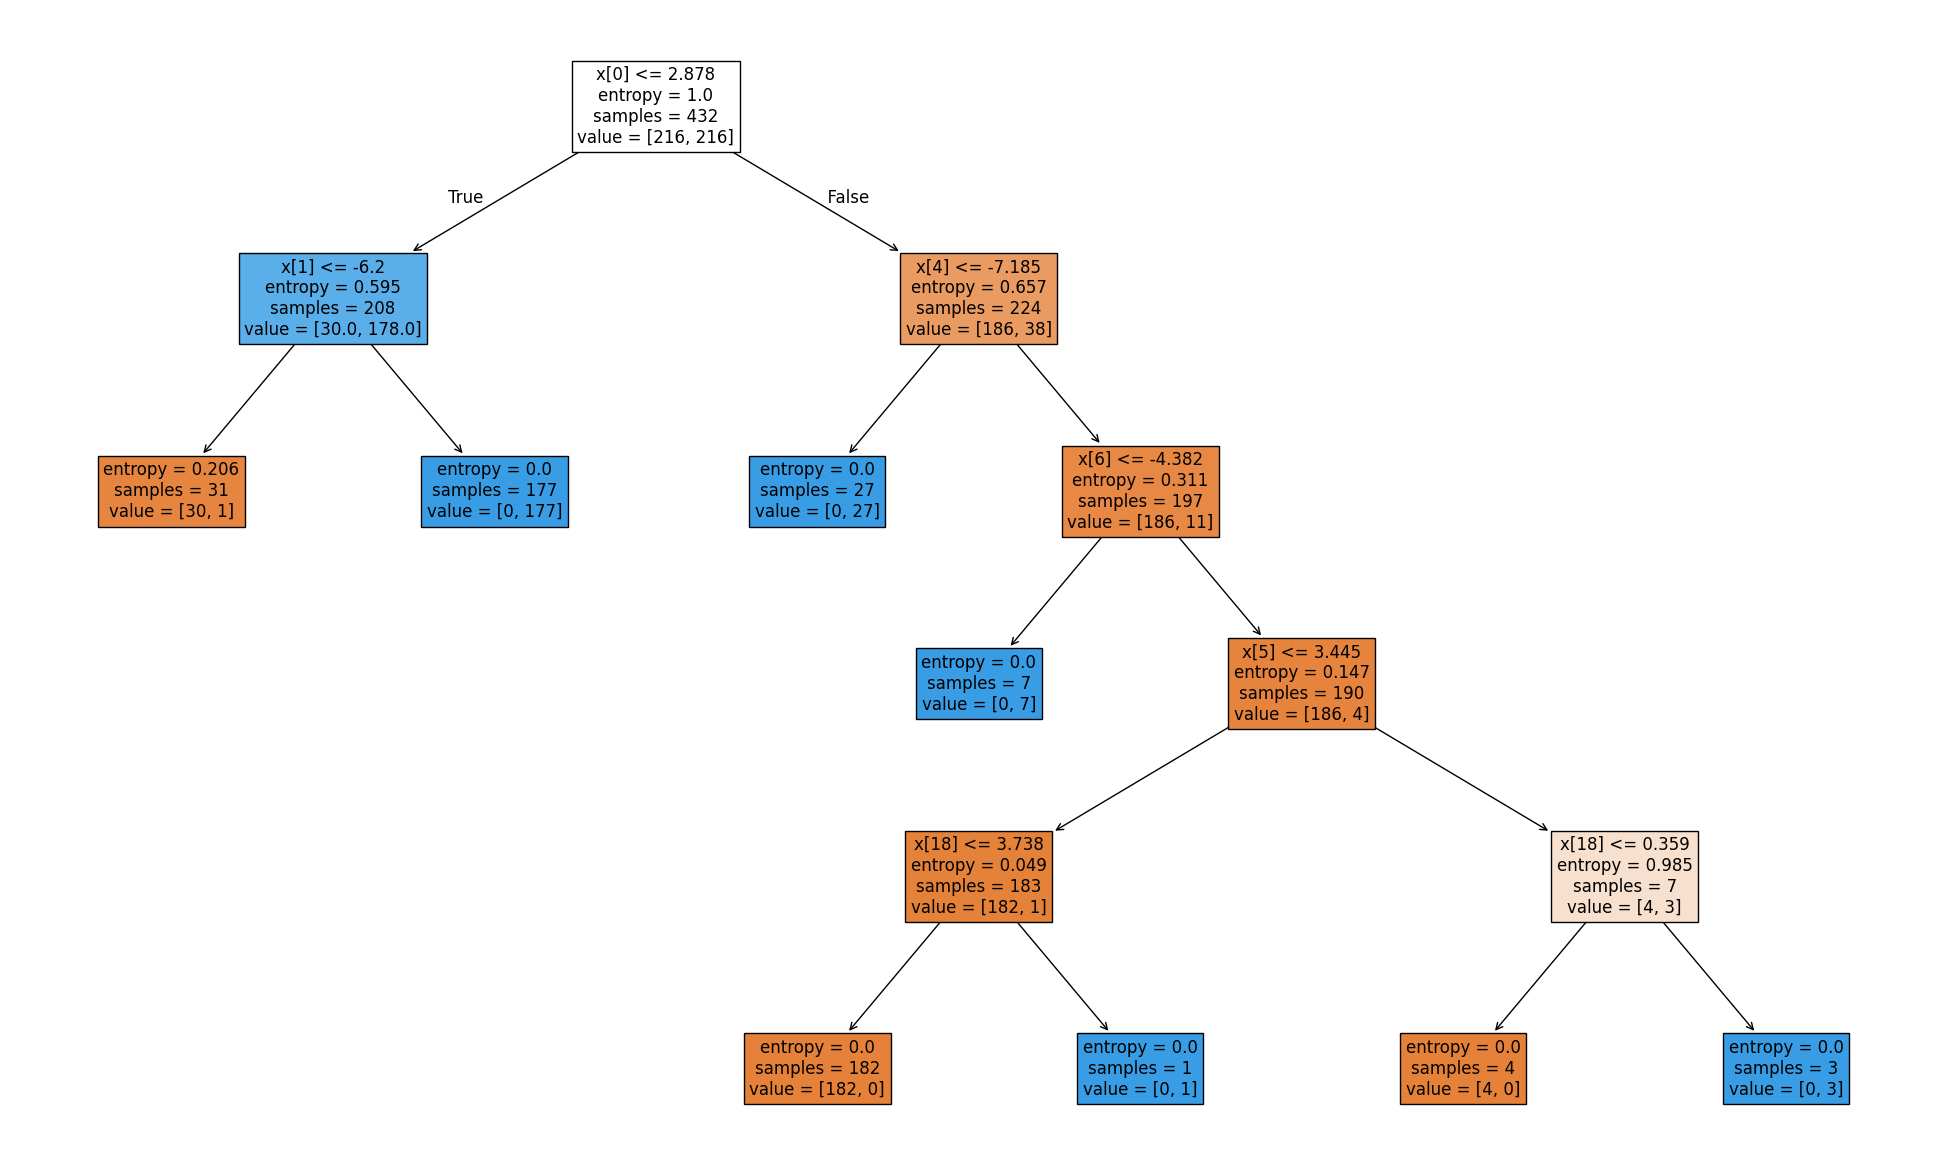

In [48]:
mejor_alpha_pca = func_arbol(x_train_pca_norm, y_train, x_test_pca_norm, y_test, x_validacion_pca_norm , y_validacion)
arbol_final_pca = DecisionTreeClassifier(random_state=22, criterion='entropy', ccp_alpha=mejor_alpha_pca)
arbol_final_pca.fit(x_train_pca_norm, y_train)
y_pred_test = arbol_final_pca.predict(x_test_pca_norm)
accuracy_arbol_pca = accuracy_score(y_test, y_pred_test)
print("Accuracy en el conjunto de prueba:", accuracy_arbol_pca)
print("mejor alpha" , mejor_alpha_pca)

plt.figure(figsize=(25,15))
plot_tree(arbol_final_pca, filled=True , fontsize=12)
plt.show()

In [49]:
from IPython.display import Markdown

tabla = f"""
| Modelo                                   | Accuracy (sin PCA) | Accuracy (con PCA) |
|------------------------------------------|-------------------:|-------------------:|
| **Regresión Logística**                  | {accuracy_rl:.4f}  | {accuracy_rl_pca:.4f} |
| **Análisis Discriminante Lineal (LDA)**  | {accuracy_lda:.4f} | {acc_lda_pca:.4f} |
| **Análisis Discriminante Cuadrático (QDA)** | {accuracy_qda_final:.4f} | {accuracy_qda_pca:.4f} |
| **K-Nearest Neighbors (KNN)**            | {acc_knn_test:.4f} | {accuracy_knn_pca:.4f} |
| **SVM (kernel RBF)**                     | {accuracy_svm:.4f} | {accuracy_svm_pca:.4f} |
| **Árbol de Decisión**                    | {accuracy_arbol:.4f} | {accuracy_arbol_pca:.4f} |
"""

display(Markdown(tabla))



| Modelo                                   | Accuracy (sin PCA) | Accuracy (con PCA) |
|------------------------------------------|-------------------:|-------------------:|
| **Regresión Logística**                  | 0.6769  | 0.7078 |
| **Análisis Discriminante Lineal (LDA)**  | 0.6200 | 0.6656 |
| **Análisis Discriminante Cuadrático (QDA)** | 0.8185 | 0.7601 |
| **K-Nearest Neighbors (KNN)**            | 0.6931 | 0.7113 |
| **SVM (kernel RBF)**                     | 0.7604 | 0.8185 |
| **Árbol de Decisión**                    | 0.7268 | 0.7005 |


Analizando los resultados de accuracy obtenidos, se puede concluir que los modelos lineales mejoran luego de la reducción por PCA, esto debido a la reducción de la dimensionalidad, lo que posibilita un menor solapado entre las clases y una mejor separación en el espacio proyectado. En particular, el LDA muestra una leve mejora de rendimiento, evidenciando que la transformación PCA contribuye a eliminar ruido y redundancia en los datos.

Por otro lado, los modelos no lineales presentan comportamientos distintos. El  el SVM mejora los desempeños generales, alcanzando valores de accuracy, lo que indica que las relaciones entre las variables no son puramente lineales y que la capacidad de modelar fronteras complejas resulta ventajosa.

En cuanto al QDA, su rendimiento disminuye tras la aplicación de PCA. Esto se debe a que la reducción de dimensionalidad implica considerar un menor número de características, lo que limita la capacidad del modelo para estimar correctamente las matrices de covarianza de cada clase. Dado que el QDA se basa en modelar la forma y dispersión de los datos en cada clase, perder dimensiones relevantes afecta directamente su capacidad de representar adecuadamente la distribución original, resultando en un peor desempeño.

El KNN tambien mejora levemente al aplicar pca, esto se puede dar debido a que utilizas caracteristicas mas importantes al observar a los vecinos, lo cual hace que tenga menos errores de prediccion.

El árbol de decisión empeora tras aplicar PCA porque esta transformación distorsiona las relaciones originales entre las variables y reduce la efectividad de las divisiones jerárquicas que el modelo usa para clasificar, tambien como se normaliza antes de aplicar pca, esto puede afectar a la logica de decision del arbol.